/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `initial_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


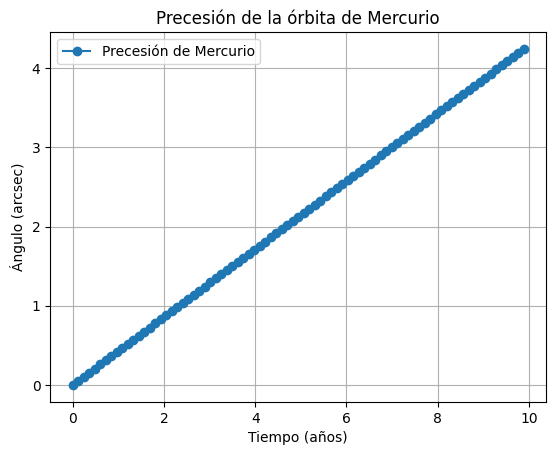

La pendiente y precesión anómala calculada fue de 42.9505 arcsec/siglo, lo cual está bastante cerca del valor real.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Definiendo variables
miu = 39.4234021
alpha = 1.09778201e-8
e = 0.20563069
a = 0.38709893
xo = a * (1 + e)
vxo = 0
yo = 0
vyo = np.sqrt((miu / a) * (1 - e) / (1 + e))
m = 1
condicioneso = np.array([xo, yo, vxo, vyo], dtype=float)

# Definiendo la función del sistema
def func(m, miu, r, alpha):
    return -m * (miu / (r ** 2) * (1 + (alpha / (r ** 2))))

def system(t, y):
    x, yd, vx, vy = y
    r = np.sqrt(x**2 + yd**2)
    fx = func(m, miu, r, alpha) * (x / r)
    fy = func(m, miu, r, alpha) * (yd / r)
    return np.array([vx, vy, fx, fy], dtype=float)

# Resolver el sistema de ecuaciones diferenciales
resultado = solve_ivp(
    system,
    t_span=(0, 10),
    y0=condicioneso,
    method="RK45",
    rtol=1e-6,
    atol=1e-9,
    t_eval=np.linspace(0, 10, 10000),
    dense_output=True
)

# Definir evento para detectar precesión
def evento(t, y):
    x, yd, vx, vy = y
    return x * vx + yd * vy

resultado = solve_ivp(
    system,
    t_span=(0, 10),
    y0=condicioneso,
    initial_step=1e-5,
    max_step=1e-4,
    method="RK45",
    events=evento
)

# Calcular ángulos en radianes
angulos_r = np.arctan2(resultado.y_events[0][:, 1], resultado.y_events[0][:, 0])

# Ajustar los ángulos
for i in range(len(angulos_r)):
    if np.isclose(angulos_r[i], np.pi, 0.1):
        angulos_r[i] -= np.pi
    elif np.isclose(angulos_r[i], np.pi * 2, 0.1):
        angulos_r[i] -= np.pi * 2
    elif np.isclose(angulos_r[i], -np.pi, 0.1):
        angulos_r[i] += np.pi

# Convertir a arcsec
pasado_arcsec = angulos_r * 3600 * 180 / np.pi
tiempo = resultado.t_events[0]

# Graficar la precesión de la órbita de Mercurio
plt.plot(tiempo, pasado_arcsec, "o-", label="Precesión de Mercurio")
plt.xlabel("Tiempo (años)")
plt.ylabel("Ángulo (arcsec)")
plt.title("Precesión de la órbita de Mercurio")
plt.grid(True)
plt.legend()
plt.show()

# Calcular pendiente y precesión anómala
pendiente = 100 * (pasado_arcsec[-1] - pasado_arcsec[0]) / (tiempo[-1] - tiempo[0])
print(f"La pendiente y precesión anómala calculada fue de {round(pendiente, 4)} arcsec/siglo, lo cual está bastante cerca del valor real.")


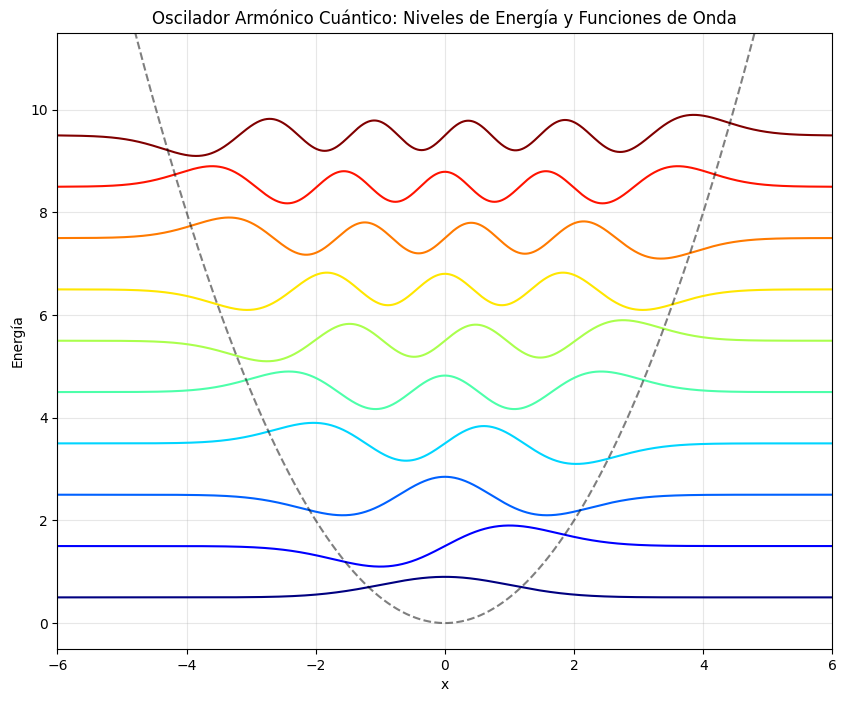

Energías Permitidas:
 Energías Simétricas  Energías Antisimétricas
            0.499977                 1.499691
            2.499535                 3.499334
            4.499135                 5.498877
            6.498627                 7.498362
            8.498139                 9.497839


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import brentq
import pandas as pd

# Ecuación de Schrödinger como un sistema de EDOs de primer orden:
# y = [f, f'] => y' = [f', (x² - 2E)f]
def schrodinger(x, y, E):
    return [y[1], (x ** 2 - 2 * E) * y[0]]

def resolver_funcion_onda(E, simetrica=True, x_max=6, num_puntos=1000):
    x_eval = np.linspace(0, x_max, num_puntos)
    y0 = [1, 0] if simetrica else [0, 1]
    sol = solve_ivp(schrodinger, (0, x_max), y0, args=(E,), t_eval=x_eval, method='RK45')
    return sol.t, sol.y[0]

def condicion_de_frontera(E, simetrica=True):
    _, f = resolver_funcion_onda(E, simetrica=simetrica)
    return f[-1]  # Valor en la frontera en x_max para verificar divergencia

def encontrar_energias_permitidas(simetrica=True, num_energias=5, rango_busqueda=(0, 20)):
    energias = []
    valores_E = np.linspace(rango_busqueda[0], rango_busqueda[1], 500)
    valores_f = [condicion_de_frontera(E, simetrica) for E in valores_E]

    for i in range(len(valores_E) - 1):
        if valores_f[i] * valores_f[i + 1] < 0:
            raiz_E = brentq(condicion_de_frontera, valores_E[i], valores_E[i + 1], args=(simetrica,))
            energias.append(raiz_E)
            if len(energias) >= num_energias:
                break

    return energias

def graficar_niveles_de_energia_y_funciones_onda(energias, x_max=6, num_puntos=1000):
    x = np.linspace(-x_max, x_max, num_puntos)
    V = 0.5 * x ** 2  # Potencial armónico

    plt.figure(figsize=(10, 8))
    colores = plt.cm.jet(np.linspace(0, 1, len(energias)))

    for i, (E, color) in enumerate(zip(energias, colores)):
        x_pos, f_pos = resolver_funcion_onda(E, simetrica=(i % 2 == 0), x_max=x_max, num_puntos=num_puntos)

        # Extender la solución simétricamente para evitar salto en x=0
        if i % 2 == 0:  # Función de onda simétrica
            x_completo = np.concatenate((-x_pos[::-1], x_pos))
            f_completo = np.concatenate((f_pos[::-1], f_pos))
        else:  # Función de onda antisimétrica
            x_completo = np.concatenate((-x_pos[::-1], x_pos))
            f_completo = np.concatenate((-f_pos[::-1], f_pos))

        # Escalar y desplazar la función de onda para visualización
        f_escalada = f_completo / np.max(np.abs(f_completo)) * 0.4 + E
        plt.plot(x_completo, f_escalada, color=color, linewidth=1.5)

    # Graficar la curva de energía potencial
    plt.plot(x, V, 'k--', alpha=0.5, label='Potencial V(x)')

    plt.xlabel('x')
    plt.ylabel('Energía')
    plt.title('Oscilador Armónico Cuántico: Niveles de Energía y Funciones de Onda')
    plt.ylim(-0.5, max(energias) + 2)
    plt.xlim(-x_max, x_max)
    plt.grid(True, alpha=0.3)
    plt.show()

# Encontrar energías permitidas (primeras 5 energías simétricas + antisimétricas combinadas)
energias_simetricas = encontrar_energias_permitidas(simetrica=True)
energias_antisimetricas = encontrar_energias_permitidas(simetrica=False)
todas_energias = sorted(energias_simetricas + energias_antisimetricas)[:10]

# Graficar el diagrama final con funciones de onda continuas
graficar_niveles_de_energia_y_funciones_onda(todas_energias)

# Mostrar energías en un DataFrame
energias_df = pd.DataFrame({
    'Energías Simétricas': energias_simetricas,
    'Energías Antisimétricas': energias_antisimetricas
})

print("Energías Permitidas:")
print(energias_df.to_string(index=False))

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


Renderizando animación:   0%|          | 0/5000 [00:00<?, ?it/s]

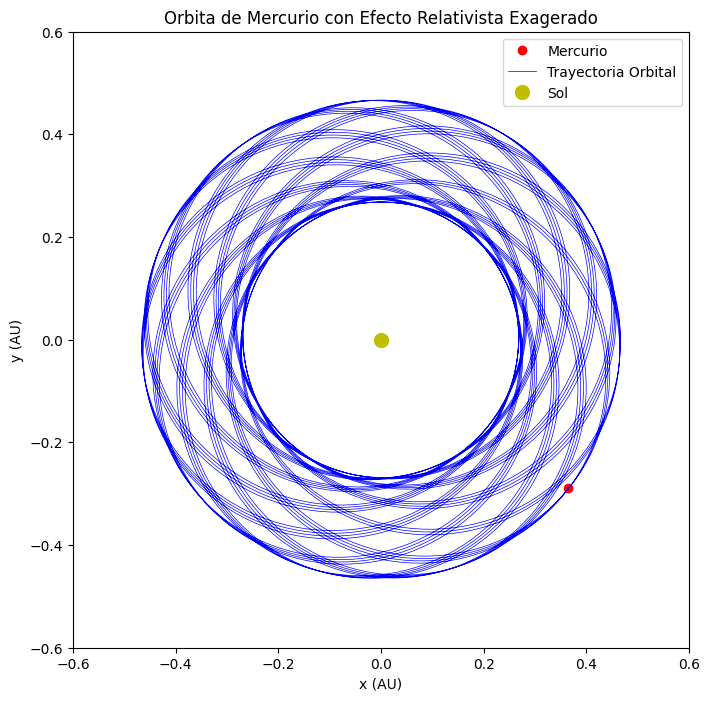

In [14]:
# Instalar paquetes requeridos (en Google Colab, ejecutar esta línea antes de ejecutar el código)
!apt-get install ffmpeg -y

# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML, display
from tqdm.notebook import tqdm

# Constantes y parámetros
mu = 39.4234021  # Parámetro gravitacional del Sol en AU³/año²
alpha_exagerado = 1e-2  # Corrección relativista exagerada para visualización

a = 0.38709893  # Semieje mayor de la órbita de Mercurio en AU
e = 0.20563069  # Excentricidad orbital

# Condiciones iniciales
x0 = a * (1 + e)
y0 = 0.0
vx0 = 0.0
vy0 = np.sqrt(mu / a * (1 - e) / (1 + e))

# Ecuaciones de movimiento
def ecuaciones(t, estado, mu, alpha):
    x, y, vx, vy = estado
    r = np.sqrt(x**2 + y**2)
    if r == 0:
        raise ValueError("Se encontró una división por cero: el radio es cero.")
    factor = -mu / r**3 * (1 + alpha / r**2)
    ax = factor * x
    ay = factor * y
    return [vx, vy, ax, ay]

# Parámetros de tiempo
t_span = (0, 10)  # Simular por 10 años
t_eval = np.linspace(t_span[0], t_span[1], 5000)

# Resolver las ecuaciones de movimiento
sol = solve_ivp(
    ecuaciones,
    t_span,
    [x0, y0, vx0, vy0],
    args=(mu, alpha_exagerado),
    t_eval=t_eval,
    method='RK45',
    rtol=1e-9,
    atol=1e-9
)

# Verificar si la solución fue exitosa
if not sol.success:
    raise RuntimeError(f"La integración falló: {sol.message}")

# Extraer los arrays de solución
x, y = sol.y[0], sol.y[1]

# Crear animación
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
ax.set_aspect('equal')
ax.set_title('Orbita de Mercurio con Efecto Relativista Exagerado')
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')
planeta, = ax.plot([], [], 'ro', label='Mercurio')
linea_orbita, = ax.plot([], [], 'b-', lw=0.5, label='Trayectoria Orbital')
ax.plot(0, 0, 'yo', markersize=10, label='Sol')
ax.legend()

# Agregar barra de progreso con tqdm
frames = len(t_eval)
barra_progreso = tqdm(total=frames, desc="Renderizando animación")

def init():
    planeta.set_data([], [])
    linea_orbita.set_data([], [])
    return planeta, linea_orbita

def actualizar(frame):
    if frame >= len(x):
        frame = len(x) - 1  # Evitar error de índice
    planeta.set_data([x[frame]], [y[frame]])
    linea_orbita.set_data(x[:frame + 1], y[:frame + 1])
    barra_progreso.update(1)
    return planeta, linea_orbita

# Crear y guardar la animación como un archivo MP4
nombre_mp4 = 'orbita_mercurio.mp4'
escritor = FFMpegWriter(fps=30, metadata={'title': 'Simulación de la Órbita de Mercurio'})

with escritor.saving(fig, nombre_mp4, dpi=100):
    ani = FuncAnimation(fig, actualizar, frames=frames, init_func=init, blit=True, interval=20)
    ani.save(nombre_mp4, writer=escritor)

barra_progreso.close()  # Cerrar la barra de progreso después de completar la renderización

# Mostrar la animación en línea
HTML(f'<video controls src="{nombre_mp4}" width="600"></video>')


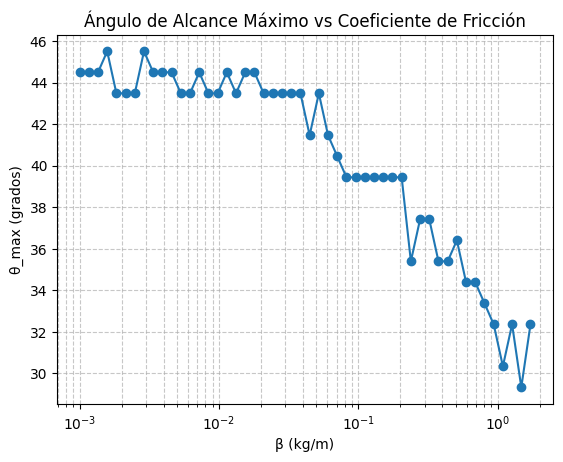

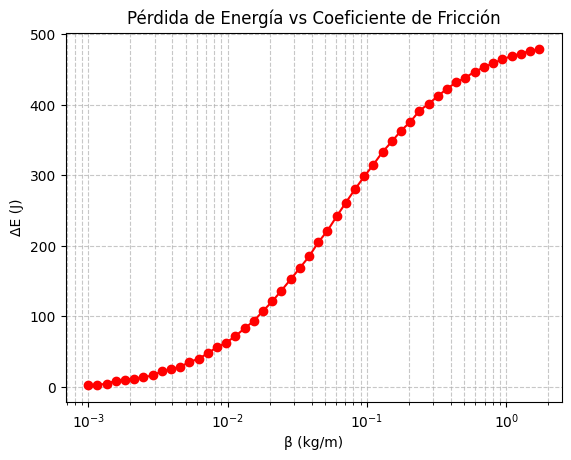

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# Constantes
m = 10  # masa (kg)
v0 = 10  # velocidad inicial (m/s)
g = 9.773  # gravedad en Bogotá (m/s²)

@njit
def paso_rk4(estado, dt, beta):
    """ Integrador de Runge-Kutta de cuarto orden (RK4) optimizado con Numba. """
    def derivadas(s):
        vx, vy, x, y = s
        v = np.hypot(vx, vy)
        dvx = -beta * vx * v
        dvy = -g - beta * vy * v
        return np.array([dvx, dvy, vx, vy])  # Corregí el retorno del último valor

    k1 = derivadas(estado)
    k2 = derivadas(estado + 0.5 * dt * k1)
    k3 = derivadas(estado + 0.5 * dt * k2)
    k4 = derivadas(estado + dt * k3)

    return estado + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

@njit
def simular(theta, beta, dt=0.01):
    """ Simulación del proyectil hasta que toca el suelo con resistencia cuadrática. """
    vx, vy = v0 * np.cos(theta), v0 * np.sin(theta)
    estado = np.array([vx, vy, 0.0, 0.0])
    energia_inicial = 0.5 * m * v0**2

    while estado[3] >= 0:
        estado = paso_rk4(estado, dt, beta)

    velocidad_final = np.hypot(estado[0], estado[1])
    energia_final = 0.5 * m * velocidad_final**2
    perdida_energia = energia_inicial - energia_final

    return estado[2], perdida_energia  # Retorna alcance horizontal y pérdida de energía

@njit
def encontrar_angulo_maximo(beta):
    """ Encuentra el ángulo que maximiza el alcance para un valor de beta. """
    angulos = np.linspace(0, np.pi / 2, 90)
    alcances = np.empty_like(angulos)

    for i in range(len(angulos)):
        alcances[i], _ = simular(angulos[i], beta)

    max_idx = np.argmax(alcances)
    return np.degrees(angulos[max_idx])

# Calcular resultados para diferentes valores de beta
betas = np.logspace(-3, np.log10(2), 50, endpoint=False)
angulos_maximos = np.empty_like(betas)
perdidas_energia = np.empty_like(betas)

for i in range(len(betas)):
    beta = betas[i]
    theta_max = encontrar_angulo_maximo(beta)
    angulos_maximos[i] = theta_max
    _, perdida_energia = simular(np.radians(theta_max), beta)
    perdidas_energia[i] = perdida_energia

# Graficar θ_max vs β
plt.figure()
plt.plot(betas, angulos_maximos, marker='o')
plt.xscale('log')
plt.xlabel("β (kg/m)")
plt.ylabel("θ_max (grados)")
plt.title("Ángulo de Alcance Máximo vs Coeficiente de Fricción")
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.show()

# Graficar ΔE vs β
plt.figure()
plt.plot(betas, perdidas_energia, marker='o', color='red')
plt.xscale('log')
plt.xlabel("β (kg/m)")
plt.ylabel("ΔE (J)")
plt.title("Pérdida de Energía vs Coeficiente de Fricción")
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.show()


2.a) P_teo = 151.98296; P_sim = 151.97848


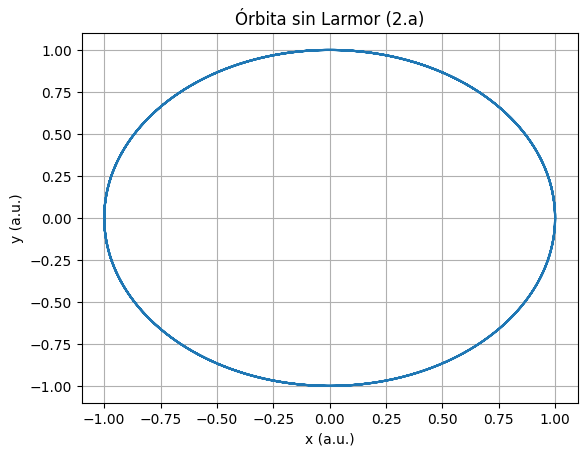

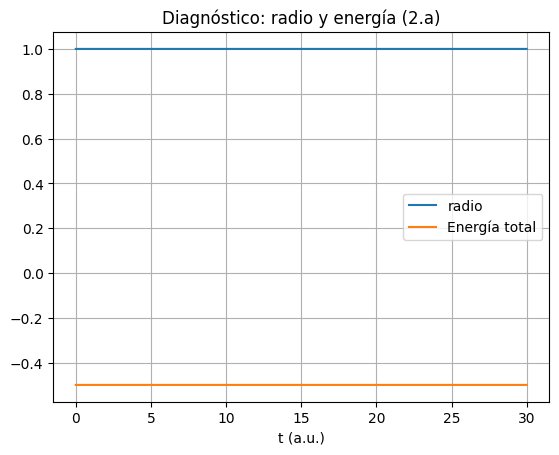

2.b) t_fall = 355.44291 as


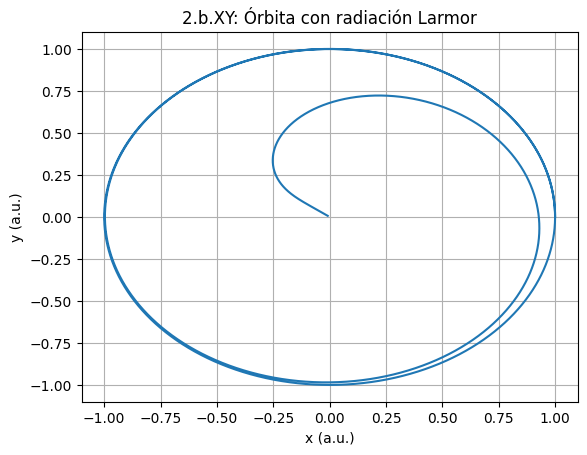

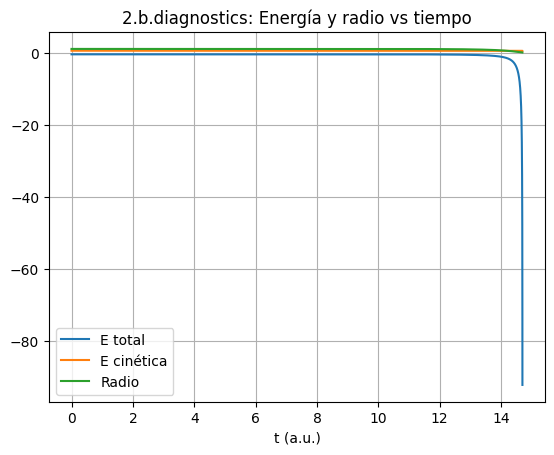

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
#   Constantes y funciones auxiliares
# -------------------------------------------------------------------

# Constante de estructura fina (aprox)
alpha = 1/137.035999206

# 1 unidad atómica de tiempo (τ) ≈ 24.18884 attosegundos
# (ver https://en.wikipedia.org/wiki/Atomic_units#Atomic_unit_of_time)
AUT_to_attosec = 24.18884

def norm(vec):
    """ Devuelve la norma euclidiana de un vector en 2D. """
    return np.sqrt(vec[0]*vec[0] + vec[1]*vec[1])

def coulomb_acc(pos):
    """
    Aceleración debida a la fuerza de Coulomb en unidades atómicas.
    F = -r / |r|^3  (masa m=1 en a.u.)
    a = F = - pos / r^3
    """
    r = norm(pos)
    return -pos / r**3

# -------------------------------------------------------------------
#   Rutina de integración RK4 (sin Larmor)
# -------------------------------------------------------------------

def rk4_step(pos, vel, dt, acc_func):
    """
    Ejecuta un paso de Runge-Kutta de orden 4 para el sistema:
       dpos/dt = vel
       dvel/dt = acc_func(pos)
    """
    # k1
    k1_pos = vel
    k1_vel = acc_func(pos)

    # k2
    k2_pos = vel + 0.5*dt*k1_vel
    k2_vel = acc_func(pos + 0.5*dt*k1_pos)

    # k3
    k3_pos = vel + 0.5*dt*k2_vel
    k3_vel = acc_func(pos + 0.5*dt*k2_pos)

    # k4
    k4_pos = vel + dt*k3_vel
    k4_vel = acc_func(pos + dt*k3_pos)

    # Actualización
    pos_new = pos + (dt/6.0)*(k1_pos + 2*k2_pos + 2*k3_pos + k4_pos)
    vel_new = vel + (dt/6.0)*(k1_vel + 2*k2_vel + 2*k3_vel + k4_vel)

    return pos_new, vel_new

# -------------------------------------------------------------------
#   (2.a) Simulación SIN Larmor
# -------------------------------------------------------------------

def simulate_without_larmor(dt=0.001, tmax=10.0):
    """
    Simula el movimiento sin radiación Larmor.
    dt  : paso de tiempo en unidades atómicas.
    tmax: tiempo máximo de simulación en unidades atómicas.
    """
    # Condiciones iniciales (en a.u.)
    # x=1, y=0, vx=0, vy=1
    pos = np.array([1.0, 0.0])
    vel = np.array([0.0, 1.0])

    t_array = []
    pos_array = []
    vel_array = []

    t = 0.0
    while t < tmax:
        t_array.append(t)
        pos_array.append(pos.copy())
        vel_array.append(vel.copy())

        # Un paso de RK4
        pos, vel = rk4_step(pos, vel, dt, coulomb_acc)
        t += dt

    return np.array(t_array), np.array(pos_array), np.array(vel_array)

# -------------------------------------------------------------------
#   Cálculo del período simulado (2.a)
# -------------------------------------------------------------------

def find_period(t_array, pos_array):
    """
    Estima el período midiendo el tiempo entre dos cruces
    de y=0 con velocidad hacia arriba (por ejemplo).
    Retorna el período aproximado.
    """
    # Vamos a buscar dos veces consecutivas en que y ~ 0 y vy>0
    # (o equivalentes) para estimar una oscilación.
    y_vals = pos_array[:,1]
    crosses = []
    for i in range(1, len(y_vals)):
        if y_vals[i-1] < 0 and y_vals[i] >= 0:  # cruce ascendente
            crosses.append(i)

    if len(crosses) >= 2:
        # Periodo entre cruces consecutivos
        i1, i2 = crosses[0], crosses[1]
        T = t_array[i2] - t_array[i1]
        return T
    else:
        return np.nan  # Si no se detectan al menos 2 cruces

# -------------------------------------------------------------------
#   (2.a) Ejecutar y mostrar resultados
# -------------------------------------------------------------------

if __name__ == "__main__":
    # ---------------- 2.a SIN Larmor ----------------
    dt = 0.0005
    tmax = 30.0  # Con 30 a.u. de tiempo cubrimos varias órbitas

    t_array, pos_array, vel_array = simulate_without_larmor(dt, tmax)

    # Periodo teórico en a.u.:
    # Para r=1 y v=1 (órbita circular en a.u.), T = 2π
    T_teor_au = 2.0 * np.pi

    # Estimar periodo de la simulación
    T_sim_au = find_period(t_array, pos_array)

    # Convertir a attosegundos
    T_teor_as = T_teor_au * AUT_to_attosec
    T_sim_as  = T_sim_au  * AUT_to_attosec

    # Imprimir resultado en el formato pedido
    print(f"2.a) P_teo = {T_teor_as:.5f}; P_sim = {T_sim_as:.5f}")

    # Verificar que el radio y la energía se mantengan constantes:
    # radio ~ 1, energía = cinética + potencial
    #   E = 1/2 v^2 - 1/r   (en a.u.)
    r_vals = np.sqrt(pos_array[:,0]**2 + pos_array[:,1]**2)
    v_vals = np.sqrt(vel_array[:,0]**2 + vel_array[:,1]**2)
    E_vals = 0.5*(v_vals**2) - 1.0/r_vals

    # Ejemplo de gráficos para diagnóstico:
    # (No es obligatorio, pero ilustrativo)
    plt.figure()
    plt.plot(pos_array[:,0], pos_array[:,1])
    plt.xlabel("x (a.u.)")
    plt.ylabel("y (a.u.)")
    plt.title("Órbita sin Larmor (2.a)")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(t_array, r_vals, label="radio")
    plt.plot(t_array, E_vals, label="Energía total")
    plt.xlabel("t (a.u.)")
    plt.legend()
    plt.title("Diagnóstico: radio y energía (2.a)")
    plt.grid(True)
    plt.show()

    # ---------------- 2.b CON Larmor ----------------

    # En este caso debemos modificar el integrador para
    # "restarle" energía al finalizar cada paso.

    def rk4_step_larmor(pos, vel, dt, acc_func):
        # -- Paso normal de RK4
        pos_new, vel_new = rk4_step(pos, vel, dt, acc_func)

        # -- Cálculo de la aceleración a(t):
        #    a = |acc_func(pos)| en el paso inicial, o promedio.
        #    Aquí lo haremos con la aceleración en la posición final
        #    para aproximar. (Hay distintas variantes)
        a = norm(acc_func(pos_new))

        # -- Fórmula: d/dt (v^2/2) = -2/3 a^2 alpha^3
        # => dv^2/dt = -4/3 a^2 alpha^3
        # => v^2(t+dt) = v^2(t) - (4/3) a^2 alpha^3 dt
        #
        # Para aproximar v(t) ≈ |vel| antes del paso, podemos usar
        # la magnitud antes o después; hay varias aproximaciones.
        v_old2 = norm(vel)**2  # magnitud^2 al inicio del paso
        delta_v2 = (4./3.)*(a**2)*(alpha**3)*dt

        new_v2 = v_old2 - delta_v2
        if new_v2 < 0.0:
            # Significa que se perdió toda la energía (v^2<0 imposible),
            # es decir, el electrón cayó.
            new_v2 = 0.0

        # Escalar la velocidad final para que cumpla la nueva magnitud
        # Magnitud actual (después de RK4 sin Larmor)
        v_now2 = norm(vel_new)**2
        if v_now2 > 0 and new_v2 >= 0:
            scale = np.sqrt(new_v2 / v_now2)
            vel_new = vel_new * scale

        return pos_new, vel_new

    def simulate_with_larmor(dt=0.0005, tmax=1000.0, r_collapse=0.01):
        """
        Simula el movimiento CON radiación Larmor hasta que
        el electrón cae (r < r_collapse) o hasta tmax.
        """
        pos = np.array([1.0, 0.0])
        vel = np.array([0.0, 1.0])

        t_array = []
        pos_array = []
        vel_array = []

        t = 0.0
        while t < tmax:
            r = norm(pos)
            if r < r_collapse:
                # Se considera que "cayó"
                break

            t_array.append(t)
            pos_array.append(pos.copy())
            vel_array.append(vel.copy())

            # Un paso con Larmor
            pos, vel = rk4_step_larmor(pos, vel, dt, coulomb_acc)
            t += dt

        return np.array(t_array), np.array(pos_array), np.array(vel_array)

    # Ejecutar la simulación con Larmor
    dt_larmor = 0.0005
    tmax_larmor = 2000.0  # suficiente para que decaiga
    r_fall = 0.01

    t_array_L, pos_array_L, vel_array_L = simulate_with_larmor(dt_larmor, tmax_larmor, r_fall)

    # Tiempo de caída = último valor de t_array_L
    if len(t_array_L) > 0:
        t_fall_au = t_array_L[-1]
    else:
        t_fall_au = 0.0

    t_fall_as = t_fall_au * AUT_to_attosec
    print(f"2.b) t_fall = {t_fall_as:.5f} as")

    # Gráficas pedidas:
    # 1) Órbita XY
    plt.figure()
    plt.plot(pos_array_L[:,0], pos_array_L[:,1])
    plt.xlabel("x (a.u.)")
    plt.ylabel("y (a.u.)")
    plt.title("2.b.XY: Órbita con radiación Larmor")
    plt.grid(True)
    plt.show()

    # 2) Diagnósticos: Energía total, cinética, y radio vs tiempo
    #   E_total = 1/2 v^2 - 1/r
    r_vals_L = np.sqrt(pos_array_L[:,0]**2 + pos_array_L[:,1]**2)
    v_vals_L = np.sqrt(vel_array_L[:,0]**2 + vel_array_L[:,1]**2)
    E_kin_L = 0.5 * (v_vals_L**2)
    E_tot_L = E_kin_L - 1.0/r_vals_L

    plt.figure()
    # Energía total
    plt.plot(t_array_L, E_tot_L, label="E total")
    # Energía cinética
    plt.plot(t_array_L, E_kin_L, label="E cinética")
    # Radio
    plt.plot(t_array_L, r_vals_L, label="Radio")
    plt.xlabel("t (a.u.)")
    plt.legend()
    plt.title("2.b.diagnostics: Energía y radio vs tiempo")
    plt.grid(True)
    plt.show()
